In [1]:
!pip install torch torchvision tqdm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchvision.models import resnet18

    100% |████████████████████████████████| 519.5MB 33kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59406000 @  0x7fc492c3f2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 21.3MB/s 
    100% |████████████████████████████████| 2.0MB 4.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [17]:
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
model = resnet18(num_classes=10)

In [4]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
def train(epoch, trainloader, optimizer, criterion):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):#enumerate(tqdm(trainloader), 0):
        # get the inputs
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('epoch %d training loss: %.3f' %
            (epoch + 1, running_loss / (len(trainloader))))
    
def test(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:#tqdm(testloader)
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
                                    100 * correct / total))
    
def classwise_test(testloader, model):
########################################################################
# class-wise accuracy

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:#tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))


In [12]:
num_epochs = 6
learning_rate = 0.001
# transfer the model to GPU
if torch.cuda.is_available():
    model = model.cuda()
    print("Using GPU")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train(epoch, trainloader, optimizer, criterion)
    test(testloader, model)
    classwise_test(testloader, model)
    #torch.save(model.state_dict(), './models/model-'+str(epoch)+'.pth')

print('Finished Training')

Using GPU
epoch  1
epoch 1 training loss: 0.991
Accuracy of the network on the 10000 test images: 66 %
Accuracy of plane : 87 %
Accuracy of   car : 62 %
Accuracy of  bird : 40 %
Accuracy of   cat : 14 %
Accuracy of  deer : 60 %
Accuracy of   dog : 75 %
Accuracy of  frog : 83 %
Accuracy of horse : 76 %
Accuracy of  ship : 81 %
Accuracy of truck : 85 %
epoch  2
epoch 2 training loss: 0.750
Accuracy of the network on the 10000 test images: 74 %
Accuracy of plane : 79 %
Accuracy of   car : 94 %
Accuracy of  bird : 56 %
Accuracy of   cat : 42 %
Accuracy of  deer : 79 %
Accuracy of   dog : 80 %
Accuracy of  frog : 77 %
Accuracy of horse : 77 %
Accuracy of  ship : 78 %
Accuracy of truck : 80 %
epoch  3
epoch 3 training loss: 0.595
Accuracy of the network on the 10000 test images: 78 %
Accuracy of plane : 85 %
Accuracy of   car : 86 %
Accuracy of  bird : 61 %
Accuracy of   cat : 45 %
Accuracy of  deer : 82 %
Accuracy of   dog : 77 %
Accuracy of  frog : 88 %
Accuracy of horse : 80 %
Accuracy of

In [0]:
#Load imagenet pretrained model
import torch.utils.model_zoo as model_zoo
model_url = 'https://download.pytorch.org/models/resnet18-5c106cde.pth'
#model.load_state_dict(model_zoo.load_url(model_url))
a = model_zoo.load_url(model_url)

In [21]:
a

OrderedDict([('conv1.weight', Parameter containing:
              tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
                          1.7083e-02, -1.2694e-02],
                        [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
                         -1.2907e-01,  3.7424e-03],
                        [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
                          2.5632e-01,  6.3573e-02],
                        ...,
                        [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
                         -4.2058e-01, -2.5781e-01],
                        [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
                          3.9359e-01,  1.6606e-01],
                        [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
                         -8.2230e-02, -5.7828e-03]],
              
                       [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
          

In [22]:
print(a['fc.weight'].shape)
print(a['fc.bias'].shape)

torch.Size([1000, 512])
torch.Size([1000])


In [0]:
del a['fc.weight']
del a['fc.bias']

In [0]:
import numpy as np
b = np.random.uniform(-1,1,(10,512))
b = torch.from_numpy(b)
a.update({'fc.weight':b})
b = np.random.uniform(-1,1,10)
b = torch.from_numpy(b)
a.update({'fc.bias':b})

In [60]:
a

OrderedDict([('conv1.weight', Parameter containing:
              tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
                          1.7083e-02, -1.2694e-02],
                        [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
                         -1.2907e-01,  3.7424e-03],
                        [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
                          2.5632e-01,  6.3573e-02],
                        ...,
                        [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
                         -4.2058e-01, -2.5781e-01],
                        [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
                          3.9359e-01,  1.6606e-01],
                        [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
                         -8.2230e-02, -5.7828e-03]],
              
                       [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
          

In [9]:
a['fc.bias'].requires_grad
a['fc.weight'].requires_grad

False

In [0]:
a['fc.bias'] = torch.tensor(a['fc.bias'], requires_grad=True)
a['fc.weight'] = torch.tensor(a['fc.weight'], requires_grad=True)


In [63]:
a

OrderedDict([('conv1.weight', Parameter containing:
              tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
                          1.7083e-02, -1.2694e-02],
                        [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
                         -1.2907e-01,  3.7424e-03],
                        [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
                          2.5632e-01,  6.3573e-02],
                        ...,
                        [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
                         -4.2058e-01, -2.5781e-01],
                        [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
                          3.9359e-01,  1.6606e-01],
                        [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
                         -8.2230e-02, -5.7828e-03]],
              
                       [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
          

In [0]:
model.load_state_dict(a)

In [30]:
num_epochs = 6
learning_rate = 0.00005

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train(epoch, trainloader, optimizer, criterion)
    test(testloader, model)
    classwise_test(testloader, model)
    #torch.save(model.state_dict(), './models/model-'+str(epoch)+'.pth')

print('Finished Training')

epoch  1
epoch 1 training loss: 0.075
Accuracy of the network on the 10000 test images: 91 %
Accuracy of plane : 93 %
Accuracy of   car : 95 %
Accuracy of  bird : 89 %
Accuracy of   cat : 83 %
Accuracy of  deer : 91 %
Accuracy of   dog : 87 %
Accuracy of  frog : 95 %
Accuracy of horse : 93 %
Accuracy of  ship : 93 %
Accuracy of truck : 94 %
epoch  2
epoch 2 training loss: 0.058
Accuracy of the network on the 10000 test images: 91 %
Accuracy of plane : 93 %
Accuracy of   car : 95 %
Accuracy of  bird : 89 %
Accuracy of   cat : 83 %
Accuracy of  deer : 92 %
Accuracy of   dog : 87 %
Accuracy of  frog : 95 %
Accuracy of horse : 91 %
Accuracy of  ship : 94 %
Accuracy of truck : 94 %
epoch  3
epoch 3 training loss: 0.050
Accuracy of the network on the 10000 test images: 91 %
Accuracy of plane : 94 %
Accuracy of   car : 95 %
Accuracy of  bird : 87 %
Accuracy of   cat : 82 %
Accuracy of  deer : 91 %
Accuracy of   dog : 88 %
Accuracy of  frog : 96 %
Accuracy of horse : 93 %
Accuracy of  ship : 9

In [29]:
a = model_zoo.load_url(model_url)
del a['fc.weight']
del a['fc.bias']
b = np.random.uniform(-1,1,(10,512))
b = torch.from_numpy(b)
a.update({'fc.weight':b})
b = np.random.uniform(-1,1,10)
b = torch.from_numpy(b)
a.update({'fc.bias':b})
for k in a:
  a[k] = torch.tensor(a[k], requires_grad=False)
a['fc.bias'] = torch.tensor(a['fc.bias'], requires_grad=True)
a['fc.weight'] = torch.tensor(a['fc.weight'], requires_grad=True)
model.load_state_dict(a)
num_epochs = 6
learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train(epoch, trainloader, optimizer, criterion)
    test(testloader, model)
    classwise_test(testloader, model)
    #torch.save(model.state_dict(), './models/model-'+str(epoch)+'.pth')

print('Finished Training')

epoch  1
epoch 1 training loss: 1.295
Accuracy of the network on the 10000 test images: 82 %
Accuracy of plane : 79 %
Accuracy of   car : 87 %
Accuracy of  bird : 72 %
Accuracy of   cat : 68 %
Accuracy of  deer : 83 %
Accuracy of   dog : 77 %
Accuracy of  frog : 89 %
Accuracy of horse : 82 %
Accuracy of  ship : 90 %
Accuracy of truck : 89 %
epoch  2
epoch 2 training loss: 0.432
Accuracy of the network on the 10000 test images: 85 %
Accuracy of plane : 91 %
Accuracy of   car : 92 %
Accuracy of  bird : 83 %
Accuracy of   cat : 76 %
Accuracy of  deer : 88 %
Accuracy of   dog : 77 %
Accuracy of  frog : 90 %
Accuracy of horse : 80 %
Accuracy of  ship : 82 %
Accuracy of truck : 88 %
epoch  3
epoch 3 training loss: 0.294
Accuracy of the network on the 10000 test images: 88 %
Accuracy of plane : 86 %
Accuracy of   car : 91 %
Accuracy of  bird : 84 %
Accuracy of   cat : 83 %
Accuracy of  deer : 86 %
Accuracy of   dog : 81 %
Accuracy of  frog : 90 %
Accuracy of horse : 91 %
Accuracy of  ship : 9

Training error: training from scratch


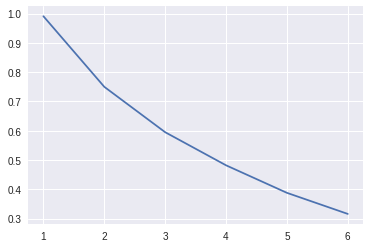

Test accuracy: training from scratch


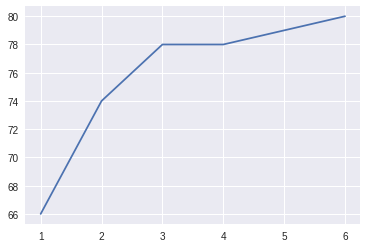

Training error: pretrained method 1


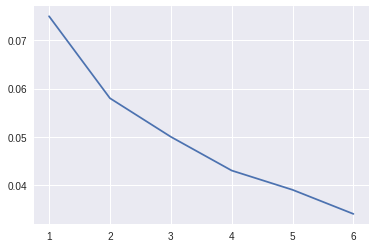

Test accuracy: pretrained method 1


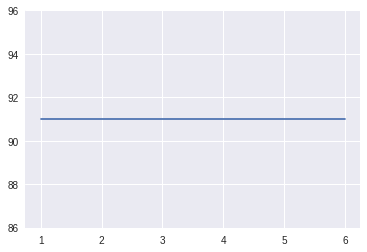

Training error: pretrained method 2


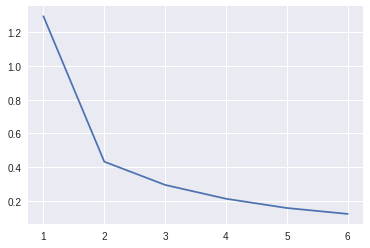

Test accuracy: pretrained method 2


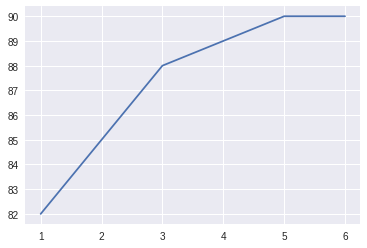

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
xaxis = np.array([1,2,3,4,5,6])
print("Training error: training from scratch")
plt.figure()
y = np.array([0.991,0.750,0.595,0.482,0.388,0.316])
plt.plot(xaxis,y)
plt.show()
print("Test accuracy: training from scratch")
plt.figure()
y = np.array([66,74,78,78,79,80])
plt.plot(xaxis,y)
plt.show()

print("Training error: pretrained method 1")
plt.figure()
y = np.array([0.075,0.058,0.050,0.043,0.039,0.034])
plt.plot(xaxis,y)
plt.show()
print("Test accuracy: pretrained method 1")
plt.figure()
y = np.array([91,91,91,91,91,91])
plt.plot(xaxis,y)
plt.show()

print("Training error: pretrained method 2")
plt.figure()
y = np.array([1.295,0.432,0.294,0.212,0.157,0.122])
plt.plot(xaxis,y)
plt.show()
print("Test accuracy: pretrained method 2")
plt.figure()
y = np.array([82,85,88,89,90,90])
plt.plot(xaxis,y)
plt.show()